In [1]:
import sys
import numpy as np
import pandas as pd

sys.path.append("..")
from dqmml.HistCollection import *
from dqmml.DQMPCA import *
import csc.utils as utils

# %matplotlib notebook
import matplotlib.pyplot as plt
sys.path.append("/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-matplotlib/1.5.2-gnimlf2/lib/python2.7/site-packages/mpl_toolkits/")
from mplot3d import Axes3D

Welcome to JupyROOT 6.12/07


# Anomaly detection in DQM histograms
Below are a selection of "DQM histograms" from a single run of the CMS experiment (e.g. a single hour of data taking). Typically a human user must sift through all of these plots (there are hundreds per run, not just the 12 shown here), and flag any that look unusual. This requires significant domain knowledge of what each of the histograms normally look like, and is also very tedious and time-consuming.

The goal is to come up with a more automated system, that can ignore the vast majority of "normal" histograms and flag a small number of unusual-looking ones for further human inspection.

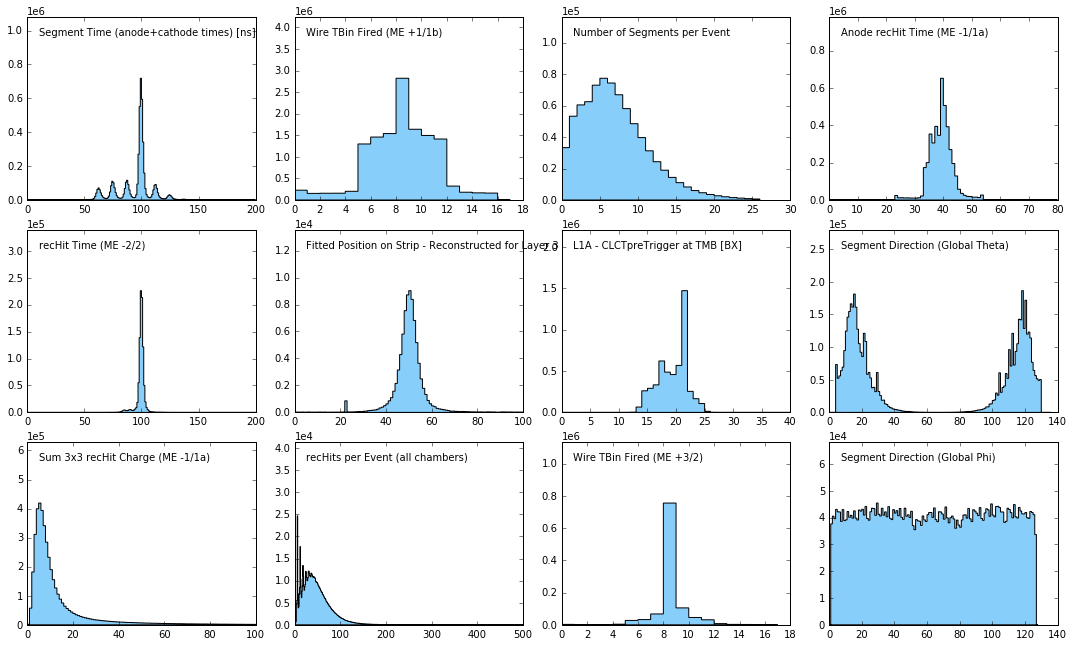

In [2]:
fig,axs = plt.subplots(3,4, figsize=(15,9))
fig.tight_layout()
axs = axs.flatten()
hist_names = [("Segments","hSTimeCombined"),("Digis","hWireTBin_p11b"),("Segments","hSnSegments"),("recHits","hRHTimingAnodem11a"),
          ("recHits","hRHTimingm22"),("Resolution","hSResidp12"),("BXMonitor","hCLCTL1A"),("Segments","hSGlobalTheta"),
          ("recHits","hRHSumQm11a"),("recHits","hRHnrechits"),("Digis","hWireTBin_p32"),("Segments","hSGlobalPhi")]
run = 301531
for i,(dname,hname) in enumerate(hist_names):
    ax = axs[i]
    hc = utils.load_hist_data(dname, hname, pkl_dir="../csc/data/{year}", lumi_json="run_info.json")
    idx = np.argmax(hc.extra_info["runs"] == run)
    hc.draw_single(idx, ax=ax)
axs[0].ticklabel_format(style='sci',axis='y',scilimits=(0,0))

### As an example, here is a single histogram (having to do with the time of a detected particle hit) shown over multiple runs. Seven are normal (though there is some variation), while the one outlined in red is an anomaly.

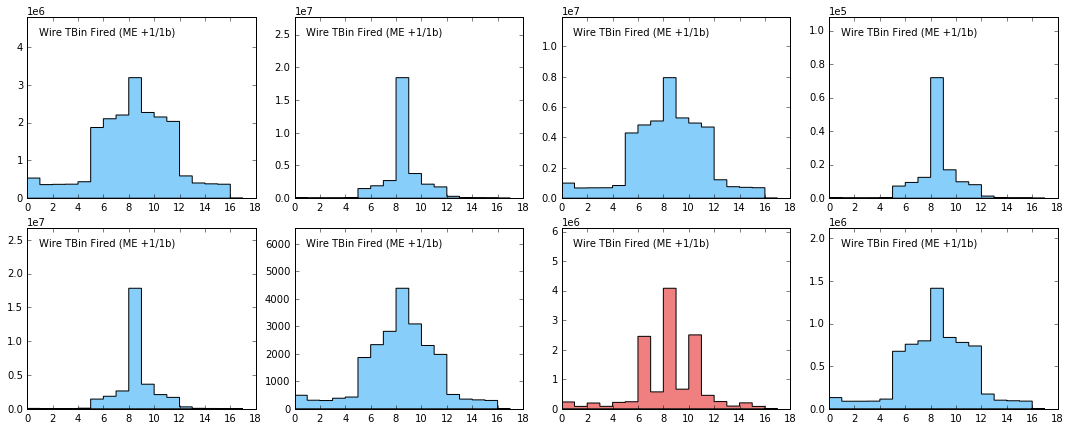

In [3]:
fig,axs = plt.subplots(2,4, figsize=(15,6))
fig.tight_layout()
axs = axs.flatten()
runs = [299395,307055,301392,306647,
        307073,304199,299614,299595]
dname, hname = "Digis","hWireTBin_p11b"
# dname, hname = "Segments", "hSTimeCombined"
hc = utils.load_hist_data(dname, hname, pkl_dir="../csc/data/{year}", lumi_json="run_info.json")
for i,run in enumerate(runs):
    ax = axs[i]
    idx = np.argmax(hc.extra_info["runs"] == run)
    hc.draw_single(idx, ax=ax, fc='lightskyblue' if i!=6 else 'lightcoral')
# for sp in ['bottom','top','left','right']:
#     axs[6].spines[sp].set_color('r')

## The data
The raw histogram data is stored in a custom format used by the CMS experiment. Auxiliary conditions for each run are stored in a SQL database. For ease of use I've extracted all of the data and saved it in pickled numpy arrays.

In order to make these tools generally applicable to other groups within CMS as well as other experiments, I've developed python classes to handle this kind of histogram data and facilitate their use in ML algorithms. Individual groups/users are responsible for translating their custom data format into 2D numpy arrays, after which these tools can be used.
* The `HistCollection` class stores a collection of histograms as a 2D histogram array (each row is a different histogram, and each column a single bin).
* This is interfaced with the `HistCleaner` class, an sklearn-style preprocessing class that manipulates the raw histogram data to facilitate use in ML algorithms. It performs two pre-processing operations:
  1. Remove bins that carry no information. If the bin is the same in every single histogram, it contains no information and can sometimes break ML algorithms. These are removed from all histograms.
  2. Normalize the histograms so that the sum of bin contents is equal to 1. Typically the overall normalization is not important, and we want to remove this.
  
Below we load a pre-stored `HistCollection` from a pickle file and examine the data. There are 721 histograms (rows), which each originally contained 17 bins. One of these (the last one) is always equal to 0.0, so it is not useful and is removed by the `HistCleaner`. The first cell displays the first 5 raw, unaltered histograms. The second shows the data after being cleaned. There is one less bin and the rows have been normalized.

In [4]:
dname, hname = "Digis","hWireTBin_p11b"
hc = utils.load_hist_data(dname, hname, pkl_dir="../csc/data/{year}", lumi_json="run_info.json")
print "Number of histograms:", hc.nhists
print "Number of bins per histogram:", hc.nbins
print "Number of good bins:", hc.hist_cleaner.n_good_bins
print "\nFirst 5 raw histograms ({0} bins):".format(hc.nbins)
pd.DataFrame(hc.hist_cleaner.restore_bad_bins(hc.hdata)*hc.norms.reshape(-1,1), columns=["bin"+str(x) for x in range(hc.nbins)]).head(5)

Number of histograms: 721
Number of bins per histogram: 17
Number of good bins: 16

First 5 raw histograms (17 bins):


,bin0,bin1,bin2,bin3,bin4,bin5,bin6,bin7,bin8,bin9,bin10,bin11,bin12,bin13,bin14,bin15,bin16
0,1258229.0,844401.0,860593.0,870618.0,1018409.0,4269342.0,4770467.0,4987753.0,7128480.0,5153032.0,4879268.0,4620606.0,1369940.0,943254.0,892481.0,865787.0,0.0
1,44151.0,30167.0,30470.0,31014.0,36779.0,160142.0,177965.0,186050.0,271698.0,192176.0,183561.0,172440.0,49691.0,33692.0,31550.0,30303.0,0.0
2,561691.0,378720.0,382389.0,386003.0,448384.0,1908244.0,2140908.0,2232815.0,3209051.0,2318183.0,2196668.0,2071259.0,610597.0,418833.0,394224.0,383723.0,0.0
3,423454.0,285212.0,287697.0,292639.0,340005.0,1403577.0,1576096.0,1640363.0,2332238.0,1700000.0,1612837.0,1523582.0,452662.0,315057.0,297257.0,285275.0,0.0
4,805821.0,547832.0,553850.0,562677.0,662023.0,3067604.0,3445499.0,3591839.0,5268109.0,3747841.0,3533305.0,3350943.0,932805.0,615396.0,577531.0,558229.0,0.0


In [5]:
print "\nFirst 5 cleaned/normalized histograms ({0} bins):".format(hc.hist_cleaner.n_good_bins)
pd.DataFrame(hc.hdata, columns=["bin"+str(x) for x in range(hc.hist_cleaner.n_good_bins)]).head(5)


First 5 cleaned/normalized histograms (16 bins):


,bin0,bin1,bin2,bin3,bin4,bin5,bin6,bin7,bin8,bin9,bin10,bin11,bin12,bin13,bin14,bin15
0,0.028128,0.018877,0.019239,0.019463,0.022767,0.095441,0.106644,0.111501,0.159357,0.115196,0.109076,0.103294,0.030625,0.021086,0.019951,0.019355
1,0.026567,0.018153,0.018335,0.018662,0.022131,0.096364,0.107089,0.111954,0.163491,0.115640,0.110456,0.103764,0.029901,0.020274,0.018985,0.018235
2,0.028026,0.018897,0.019080,0.019260,0.022373,0.095214,0.106823,0.111409,0.160119,0.115668,0.109605,0.103348,0.030466,0.020898,0.019670,0.019146
3,0.028674,0.019313,0.019481,0.019816,0.023023,0.095042,0.106724,0.111076,0.157926,0.115114,0.109212,0.103168,0.030652,0.021334,0.020129,0.019317
4,0.025323,0.017216,0.017405,0.017682,0.020804,0.096401,0.108276,0.112875,0.165553,0.117778,0.111036,0.105305,0.029314,0.019339,0.018149,0.017543


## Projecting the histograms with PCA

We can think of each histogram as a point in (NBINS)-dimensional space. NBINS is always at least 15, and sometimes can be in the hundreds, so direct visualization isn't possible.

I've created a `DQMPCA` class that acts as a wrapper around `sklearn.decomposition.PCA`, accepting `HistCollection` objects as input.

Here we load in a `HistCollection` of a specified histogram, and display the 2- and 3-dimensional PCA projections. In the left and middle plots, points are colored by run number (essentially time). Red points occur before blue points. We observe multiple distinct clusters, corresponding to discrete changes in the underlying experimental conditions/setup. In the right plot, the points are colored by "luminosity", or beam intensity. We see that the first principal component is strongly correlated to luminosity, meaning this is the main feature controlling the shapes of the histograms.

In [6]:
dname, hname = "Segments", "hSTimeCombined"
hc = utils.load_hist_data(dname, hname, pkl_dir="../csc/data/{year}", lumi_json="run_info.json")
pca = DQMPCA(norm_cut=10000, sse_ncomps=(1,2,3))
pca.fit(hc)
xf = pca.transform(hc)

In [7]:
good_idxs = (hc.norms>10000)
xf = xf[good_idxs, :]
lumis = hc.extra_info["lumis"][good_idxs]
runs = hc.extra_info["runs"][good_idxs]

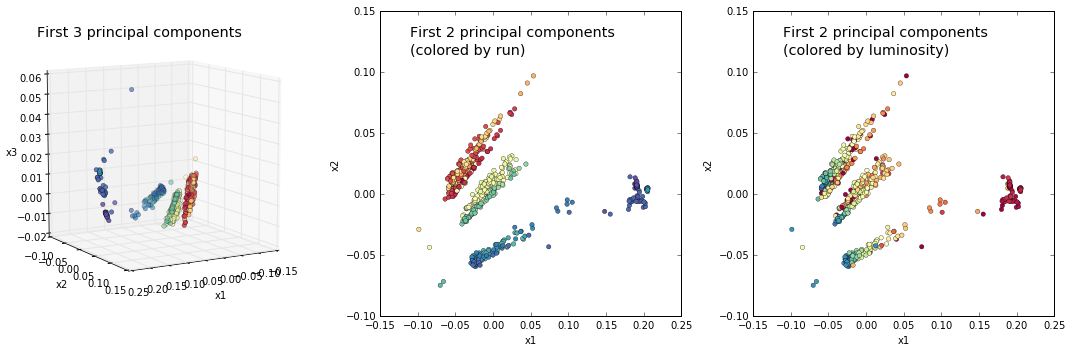

In [8]:
fig1 = plt.figure(figsize=(15,5))
ax3d = fig1.add_subplot(131, projection='3d')
ax3d.scatter(xf[:,0], xf[:,1], xf[:,2], c=runs, cmap='Spectral', vmin=np.amin(runs), vmax=np.amax(runs), linewidth=0.3)
ax3d.set_xlabel("x1")
ax3d.set_ylabel("x2")
ax3d.set_zlabel("x3")
ax3d.text2D(0.1, 0.92,"First 3 principal components", transform=ax3d.transAxes, fontsize='x-large')
ax3d.view_init(elev=10, azim=60)

ax2d = fig1.add_subplot(132)
ax2d.scatter(xf[:,0], xf[:,1], c=runs, cmap='Spectral', vmin=np.amin(runs), vmax=np.amax(runs), linewidth=0.3)
ax2d.set_xlabel("x1")
ax2d.set_ylabel("x2")
ax2d.text(0.1,0.92,"First 2 principal components", transform=ax2d.transAxes, fontsize='x-large');
ax2d.text(0.1,0.86,"(colored by run)", transform=ax2d.transAxes, fontsize='x-large');

ax2d = fig1.add_subplot(133)
ax2d.scatter(xf[:,0], xf[:,1], c=lumis, cmap='Spectral', vmin=np.amin(lumis), vmax=np.amax(lumis), linewidth=0.3)
ax2d.set_xlabel("x1")
ax2d.set_ylabel("x2")
ax2d.text(0.1,0.92,"First 2 principal components", transform=ax2d.transAxes, fontsize='x-large');
ax2d.text(0.1,0.86,"(colored by luminosity)", transform=ax2d.transAxes, fontsize='x-large');

fig1.tight_layout()

## Histograms are almost fully explained by the first few principal components

By looking at the explained variance ratio, we find that the variation between runs is almost fully explained by the first 1-3 principal components. So even though this histograms can have hundreds of bins, their underlying structure is really quite simple.

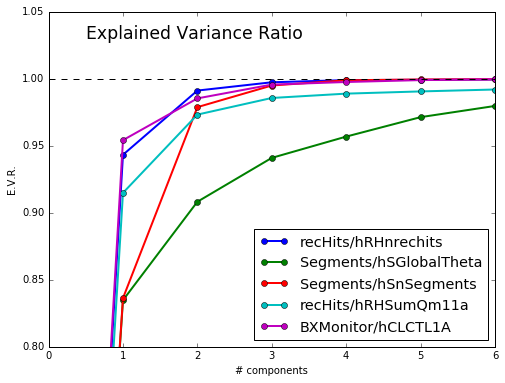

In [9]:
idxs = [8,2,9,6,7]
evrs = {}
for idx in idxs:
    dname, hname = hist_names[idx]
    hc = utils.load_hist_data(dname, hname, pkl_dir="../csc/data/{year}", lumi_json="run_info.json")
    pca = DQMPCA(norm_cut=10000)
    pca.fit(hc)
    evrs["{0}/{1}".format(dname,hname)] = np.cumsum(pca.explained_variance_ratio)
fig = plt.figure(figsize=(8,6))
for name,evr in evrs.items():
    evr = evr[:min(len(evr), 6)]
    plt.plot(np.arange(len(evr)+1), np.append([0], evr), '-o', lw=2, label=name)
plt.plot([0,6],[1,1],'k--')
plt.gca().set_ylim(0.8,1.05)
plt.legend(loc='lower right', fontsize='x-large')
plt.text(0.5, 1.03, "Explained Variance Ratio", fontsize='xx-large')
plt.xlabel("# components")
plt.ylabel("E.V.R.");

## Reconstructing histograms from principal components

A number of different anomaly-detection techniques were considered, including nearest-neighbor, clustering, and auto-encoder neural networks. In the end, due to the simple structure of the histograms, a very simple technique worked best: simply try to reconstruct the histogram from its first few principal components. These are sufficient to capture the normal variation, but any outliers are not captured. For normal histograms, the reconstructed one matches the original quite closely. For outliers, there are significant differences.

Below are a few examples for 3 histograms, with a chosen "good" example on top and "bad" (outlier) example on bottom.

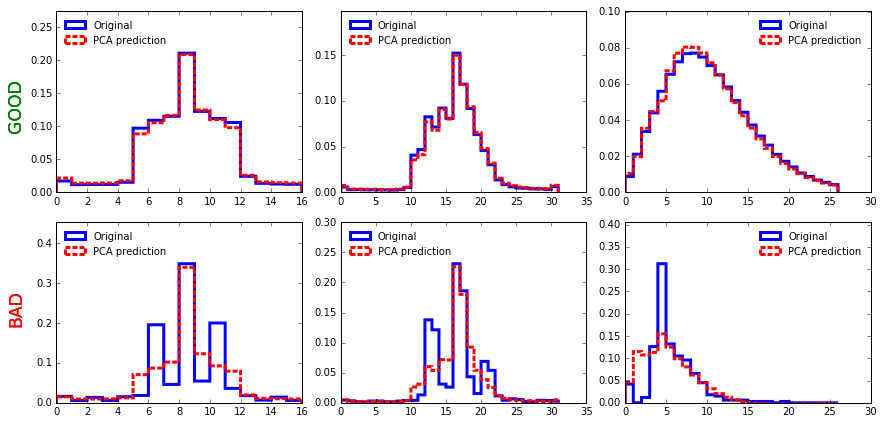

In [10]:
fig,axs = plt.subplots(2,3, figsize=(12,6))
fig.tight_layout()
plots = [ 
    # dname, hname, goodrun, badrun
    ("Digis", "hWireTBin_p11b", 301531, 299616),
    ("recHits", "hRHTimingAnodem11a", 301531, 299616),
    ("Segments", "hSnSegments", 305588, 306527),
]
for i, (dname,hname,goodrun,badrun) in enumerate(plots):
    hc = utils.load_hist_data(dname, hname, pkl_dir="../csc/data/{year}", lumi_json="run_info.json")
    pca = DQMPCA(norm_cut=10000)
    pca.fit(hc)
    evr = pca.explained_variance_ratio
    ncomp = min(np.argmax(np.cumsum(evr)>0.97)+1, 3)
    goodidx = np.argmax(hc.extra_info["runs"]==goodrun)
    badidx = np.argmax(hc.extra_info["runs"]==badrun)
    goodorig = hc.hdata[goodidx,:]
    badorig = hc.hdata[badidx,:]
    goodixf = pca.inverse_transform(pca.transform(hc), n_components=ncomp)[goodidx,:]
    badixf = pca.inverse_transform(pca.transform(hc), n_components=ncomp)[badidx,:]
    HistCollection.draw(goodorig, ax=axs[0][i], histtype='step', color='b', lw=3, label="Original")
    HistCollection.draw(goodixf, ax=axs[0][i], histtype='step', color='r', lw=3, ls=(0, (5, 2)), label="PCA prediction")
    HistCollection.draw(badorig, ax=axs[1][i], histtype='step', color='b', lw=3, label="Original")
    HistCollection.draw(badixf, ax=axs[1][i], histtype='step', color='r', lw=3, ls=(0, (5, 2)), label="PCA prediction")
    axs[0][i].set_ylim(0, np.amax(goodorig)*1.3)
    axs[1][i].set_ylim(0, np.amax(badorig)*1.3)
    for j in range(2):
        axs[j][i].legend(loc='upper left' if i<2 else 'upper right', frameon=False, fontsize='medium')
    axs[0][0].text(-0.2,0.55,"GOOD", rotation=90, transform=axs[0][0].transAxes, fontsize='xx-large', color='g')
    axs[1][0].text(-0.2,0.55,"BAD", rotation=90, transform=axs[1][0].transAxes, fontsize='xx-large', color='r')
    

## Examining performace on a test sample of histograms

As a metric to test how well the reconstruction matches the original, we used a sum of squared errors over all of the bins. Functionality to compute this is build into the `DQMPCA` class. We have extracted a test set of histograms taken from a data-taking period after the histograms used for fitting the PCAs, and gone through and manually labeled the outlier histograms. 

Below we plot the SSE values for every histogram in the test set, with the "normal" examples in green and the "outliers" in red (note the log scale on the y axis). The vast majority of good histograms have SSEs near 0. By cutting on a certain SSE value (say, anything above the 95th percentile), we can flag potential outliers for further inspection by human users.

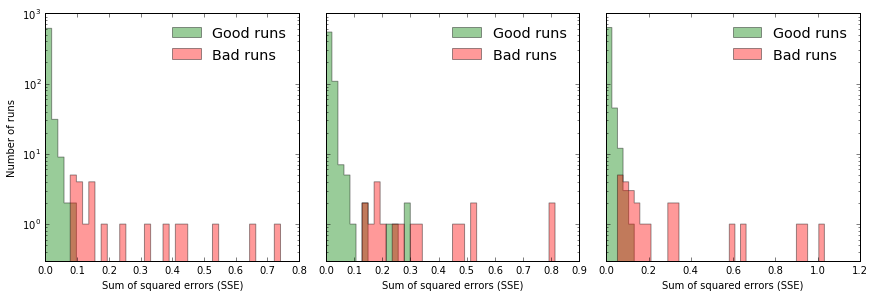

In [11]:
fig,axs = plt.subplots(1,3, figsize=(12,4), sharey=True)
fig.tight_layout()
plots = [
    ("recHits", "hRHTimingAnodem11a",1),
    ("Digis", "hWireTBin_p11b",1),
    ("Segments", "hSnSegments",3),
]
for i,(dname,hname,ncomp) in enumerate(plots):
    hc_train = utils.load_hist_data(dname, hname, pkl_dir="../csc/data/{year}", lumi_json="run_info.json")
    hc_test = utils.load_hist_data(dname, hname, pkl_dir="../csc/data/{year}_test", lumi_json="run_info.json", norm_cut=1)
    pca = DQMPCA(norm_cut=10000, sse_ncomps=(1,2,3))
    pca.fit(hc_train)
    sses = pca.sse(hc_test, n_components=ncomp)
    bad_runs = [int(x) for x in open("../csc/bad_runs/{0}_{1}".format(dname, hname)).readlines()]
    badrun_mask = map(lambda x:x in bad_runs, hc_test.extra_info["runs"])
    good_sses = sses[np.logical_not(badrun_mask)]
    bad_sses = sses[badrun_mask]
    axs[i].hist(good_sses, bins=40, range=(0,np.amax(bad_sses)+0.05), histtype='stepfilled', fc='g', alpha=0.4, label="Good runs")
    axs[i].hist(bad_sses, bins=40, range=(0,np.amax(bad_sses)+0.05), histtype='stepfilled', fc='r', alpha=0.4, label="Bad runs")
    axs[i].set_yscale('log')
    axs[i].set_ylim(3e-1, 1e3)
    axs[i].legend(frameon=False, fontsize="x-large", loc="upper right")
    axs[i].set_xlabel("Sum of squared errors (SSE)")
    if i==0:
        axs[i].set_ylabel("Number of runs")

## Ability to extrapolate to newly-seen conditions

A benefit of this "PCA-reconstruction" method, as opposed to things like clustering or nearest-neighbor algorithms is that it essentially learns the few underlying parameters that control the histograms, and can extrapolate when these parameters vary from the values seen in previous data.

As an example, the black points below represent the first 2 principal components of histograms taken during 2017 data-taking. The red points are the same but for 2018. We see that the 2018 runs form their own cluster, as the conditions were slightly different than anything seen in 2017. Nearest neighbor or clustering algorithms would have flagged the 2018 runs as outliers based on 2017 data, but the PCA-reconstruction algorithm naturally captures this normal variation and correctly sees these as non-outlier histograms.

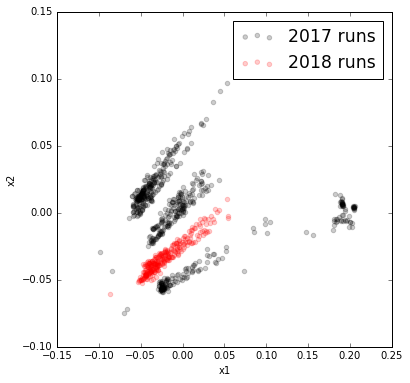

In [13]:
dname, hname = "Segments", "hSTimeCombined"
hc17 = utils.load_hist_data(dname, hname, year=2017, pkl_dir="../csc/data/{year}", lumi_json="run_info.json")
hc18 = utils.load_hist_data(dname, hname, year=2018, pkl_dir="../csc/data/{year}", lumi_json="run_info.json")
pca = DQMPCA(norm_cut=10000)
pca.fit(hc17)
gr17 = (hc17.norms>10000)
gr18 = (hc18.norms>10000)
hc18 = hc18.hist_cleaner.restore_bad_bins(hc18.hdata*hc18.norms.reshape(-1,1))
xf17 = pca.transform(hc17)[gr17,:]
xf18 = pca.transform(hc18)[gr18,:]
fig = plt.figure(figsize=(6,6))
plt.scatter(xf17[:,0], xf17[:,1], color='k', alpha=0.2, label="2017 runs")
plt.scatter(xf18[:,0], xf18[:,1], color='r', alpha=0.2, label="2018 runs")
plt.legend(frameon=True, fontsize='xx-large')
plt.xlabel('x1')
plt.ylabel('x2');